# Affine images and landmarks (pixel coordinates) without scaling effects

## method 1: torchio for 3D image, SimpleITK for landmarks  (rotation and then translation, only on CPU)

In [1]:
import time

import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchio.transforms import Affine
import torch

def vis(img, img_transformed, idx, idx_transformed):
    if torch.is_tensor(idx):
        idx = idx[0].numpy().tolist()
        idx_transformed = idx_transformed[0].numpy().tolist()
    
    x, y, z = idx
    xr, yr, zr = idx_transformed
    
    # x-y
    sl = img[int(z), :, :].astype(np.uint8)  # image d h w
    sl_color = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl_color, (round(x), round(y)), 5, (0, 255, 0))
    sl_rotated = img_transformed[round(zr), :, :].astype(np.uint8)  # image d h w
    sl_rotated_color = cv2.cvtColor(sl_rotated, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl_rotated_color, (round(xr), round(yr)), 5, (0, 255, 0))
    # x-z
    sl2 = img[:, int(y), :].astype(np.uint8)  # image d h w
    sl2_color = cv2.cvtColor(sl2, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl2_color, (round(x), round(z)), 5, (0, 255, 0))
    sl2_rotated = img_transformed[:, int(yr), :].astype(np.uint8)  # image d h w
    sl2_rotated_color = cv2.cvtColor(sl2_rotated, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl2_rotated_color, (round(xr), round(zr)), 5, (0, 255, 0))
    # y-z
    sl3 = img[:, :, int(x)].astype(np.uint8)  # image d h w
    sl3_color = cv2.cvtColor(sl3, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl3_color, (round(y), round(z)), 5, (0, 255, 0))
    sl3_rotated = img_transformed[:, :, int(xr)].astype(np.uint8)  # image d h w
    sl3_rotated_color = cv2.cvtColor(sl3_rotated, cv2.COLOR_GRAY2RGB)
    cv2.circle(sl3_rotated_color, (round(yr), round(zr)), 5, (0, 255, 0))

    plt.figure(figsize=(20, 15))
    plt.subplot(1, 6, 1)
    plt.imshow(sl_color)  # Show a slice with lm of the original image
    plt.title('Original Image (x-y)')
    plt.axis('off')
    plt.subplot(1, 6, 2)
    plt.imshow(sl_rotated_color)  # Show a slice with lm of the rotated image
    plt.title('transformed Image (x-y)')
    plt.axis('off')
    
    plt.subplot(1, 6, 3)
    plt.imshow(sl2_color)  # Show a slice with lm of the original image
    plt.title('Original Image (x-z)')
    plt.axis('off')
    plt.subplot(1, 6, 4)
    plt.imshow(sl2_rotated_color)  # Show a slice with lm of the rotated image
    plt.title('transformed Image (x-z)')
    plt.axis('off')
    plt.subplot(1, 6, 5)
    plt.imshow(sl3_color)  # Show a slice with lm of the original image
    plt.title('Original Image (y-z)')
    plt.axis('off')
    plt.subplot(1, 6, 6)
    plt.imshow(sl3_rotated_color)  # Show a slice with lm of the rotated image
    plt.title('transformed Image (y-z)')
    plt.axis('off')

y-x-z (543, 627, 1387)
rotation took 2.292327880859375 s
origin image size (543, 627, 1387) rotated image size (543, 627, 1387)


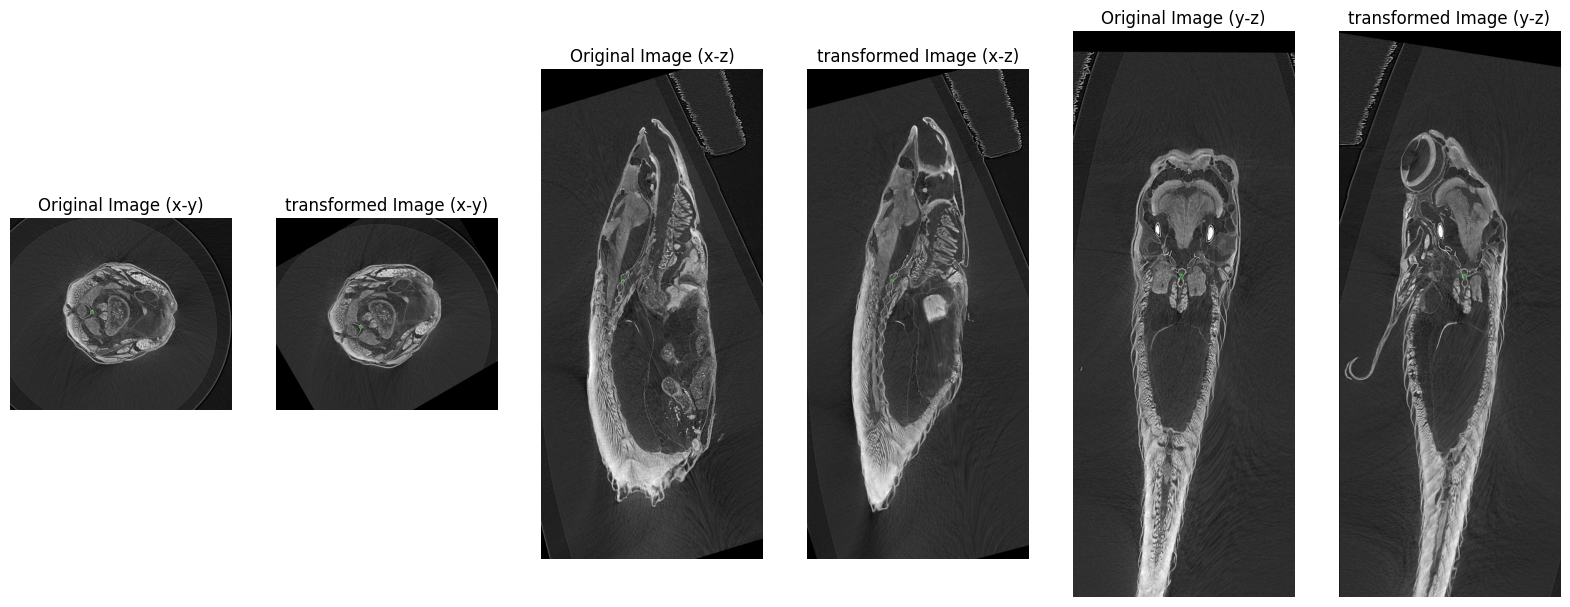

In [2]:
rotation_degrees = [0, 0, 30]
translations = [0, 0, 0]
image_affine = Affine(scales=[1.0, 1.0, 1.0], degrees=rotation_degrees, translation=translations,
                      center='image')

pos_affine = sitk.Euler3DTransform()
rotation_radians = np.radians(rotation_degrees).tolist()
pos_affine.SetRotation(*rotation_radians)
pos_affine.SetTranslation(translations)

# read image
vol_name = '417'
img_path = f'/mnt/data/medaka_landmarks/data/{vol_name}.tif'

sitk_image = sitk.ReadImage(img_path, sitk.sitkUInt8)
# Convert from [depth, width, height] to [height, width, depth]
image_data = sitk.GetArrayFromImage(sitk_image).transpose(2, 1, 0)
image_dims = image_data.shape
print("y-x-z", image_dims)

# set center for pos_affine to the center of image
image_dims = np.shape(image_data)
center = [(image_dims[0] - 1) / 2, (image_dims[1] - 1) / 2, (image_dims[2] - 1) / 2]
pos_affine.SetCenter(center)

# transform image
t0 = time.time()
image_transformed = image_affine(np.expand_dims(image_data, axis=0))[0]
print(f'rotation took {time.time() - t0} s')
print('origin image size', image_data.shape, 'rotated image size', image_transformed.shape)

# transform landmark (pixel coordinates height-width-depth y-x-z)
p = [265., 231., 600]
p_transformed = pos_affine.TransformPoint(p)

# visualization
vis(image_data.transpose(2, 0, 1), image_transformed.transpose(2, 0, 1), torch.tensor([[p[1], p[0], p[2]]]),
    torch.tensor([[p_transformed[1], p_transformed[0], p_transformed[2]]]))

## Method 2: pytorch based functions in affine.py (supports both CPU and GPU depending on device of input image tensor)

In [3]:
import torch
import numpy as np
import cv2
import SimpleITK as sitk
import time
from matplotlib import pyplot as plt

from affine import affine_3d, affine_3d_idx

In [4]:
cpu = torch.device('cpu')
cuda = torch.device('cuda:0')

### 1. example 3D image depth (z) x height (y) x width (x) = 2x4x3 

In [5]:
image = torch.tensor(list(range(24)), device=cuda).view(2, 4, 3).float()

In [6]:
# translate along z 1 pixel, rotation along z 180 degrees
translations = torch.tensor([0., 0., 1.])
rotations = torch.tensor([0, 0, np.pi])
rotated_image = affine_3d(image, rotations, translations, 'nearest')
print('orig', image.shape)
print('orig', image)
print('rotated', rotated_image.shape)
print('rotated', rotated_image.round())
original_idx = torch.tensor([[0, 0, 1]])
affine_idx = affine_3d_idx(image.shape, rotations, translations, original_idx)
print(
    f'the element {image[original_idx[0][2], original_idx[0][1], original_idx[0][0]]} at {original_idx} locates at {affine_idx} after rotation')

/home/ws/ml0077/miniconda3/envs/preprocessing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ws/ml0077/work_deepl2/preprocessing/affine.py:100: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  affine_matrix = torch.cat([rotation_matrix, translations.T.unsqueeze(-1)], dim=1).to(image.device)


orig torch.Size([2, 4, 3])
orig tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]]], device='cuda:0')
rotated torch.Size([2, 4, 3])
rotated tensor([[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[11., 10.,  9.],
         [ 8.,  7.,  6.],
         [ 5.,  4.,  3.],
         [ 2.,  1.,  0.]]], device='cuda:0')
the element 12.0 at tensor([[0, 0, 1]]) locates at tensor([[2., 3., 2.]]) after rotation


In [7]:
# translate along x 1 pixel, rotation along z 90 degrees
translations = torch.tensor([1., 0., 0.])
rotations = torch.tensor([0, 0, np.pi / 4])
rotated_image = affine_3d(image, rotations, translations, 'nearest')
print('orig', image.shape)
print('orig', image)
print('rotated', rotated_image.shape)
print('rotated', rotated_image.round())
original_idx = torch.tensor([[1, 0, 1]])
affine_idx = affine_3d_idx(image.shape, rotations, translations, original_idx)
print(
    f'the element {image[original_idx[0][2], original_idx[0][1], original_idx[0][0]]} at {original_idx} locates at {affine_idx} after rotation')

orig torch.Size([2, 4, 3])
orig tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]]], device='cuda:0')
rotated torch.Size([2, 4, 4])
rotated tensor([[[ 0.,  1.,  4.,  8.],
         [ 0.,  3.,  7.,  7.],
         [ 0.,  0.,  6., 10.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0., 13., 16., 20.],
         [ 0., 15., 19., 19.],
         [ 0.,  0., 18., 22.],
         [ 0.,  0.,  0.,  0.]]], device='cuda:0')
the element 13.0 at tensor([[1, 0, 1]]) locates at tensor([[1., 0., 1.]]) after rotation


### 2. medaka fish with landmarks

In [8]:
vol_name = '417'
img_path = f'/mnt/data/medaka_landmarks/data/{vol_name}.tif'

sitk_image = sitk.ReadImage(img_path, sitk.sitkUInt8)
# Convert from [depth, width, height] to [depth, height, width]
image_data = sitk.GetArrayFromImage(sitk_image).transpose(0, 2, 1)
image_dims = image_data.shape
print("z-y-x", image_dims)

rotations = torch.tensor([0, 0, np.pi / 6])  # width (x) height(y) depth (z)
translations = torch.tensor([50., 50., 0.])

z-y-x (1387, 543, 627)


In [9]:
# rotation on cpu (for speed comparison)
medaka_tensor = torch.tensor(image_data, device=cpu).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)
print(f"took {time.time() - t0} s")
print(medaka_rotated.shape)

took 35.41211152076721 s
torch.Size([1387, 783, 814])


In [10]:
# rotation on GPU (trilinear)
medaka_tensor = torch.tensor(image_data, device=cuda).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations)  # default trilinear
print(f"took {time.time() - t0} s")
print(medaka_rotated.shape)

took 0.14262723922729492 s
torch.Size([1387, 783, 814])


In [11]:
# rotation on GPU (nearest)
medaka_tensor = torch.tensor(image_data, device=cuda).float()
t0 = time.time()
medaka_rotated = affine_3d(medaka_tensor, rotations, translations, 'nearest')
print(f"took {time.time() - t0} s")
print(medaka_rotated.shape)

took 0.009998559951782227 s
torch.Size([1387, 783, 814])


origin image size torch.Size([1387, 543, 627]) rotated image size (1387, 543, 627)


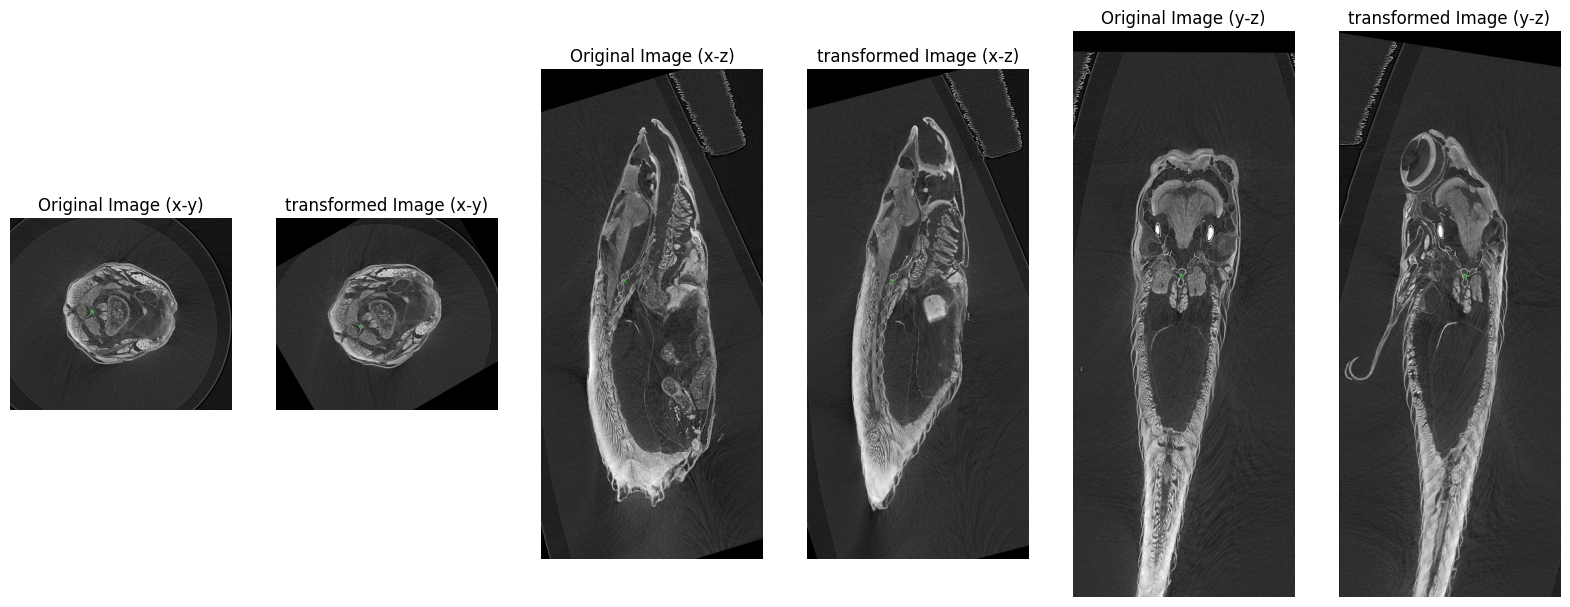

In [12]:
# translation - rotation z
rotations = torch.tensor([0, 0, np.pi / 6])  # width (x) height(y) depth (z)
translations = torch.tensor([0., 0., 0.])
# image
medaka_tensor = torch.tensor(image_data, device=cuda).float()
medaka_transformed = affine_3d(medaka_tensor, rotations, translations, keep_original_size=True).round().cpu().numpy()
print('origin image size', medaka_tensor.shape, 'rotated image size', medaka_transformed.shape)
# landmark (vert1)
p = torch.tensor([[231., 265, 600]])
p_transformed = affine_3d_idx(image_dims, rotations, translations, p,keep_original_size=True)
# visualization
vis(image_data, medaka_transformed, p, p_transformed)

origin image size torch.Size([1387, 543, 627]) rotated image size (1387, 543, 627)


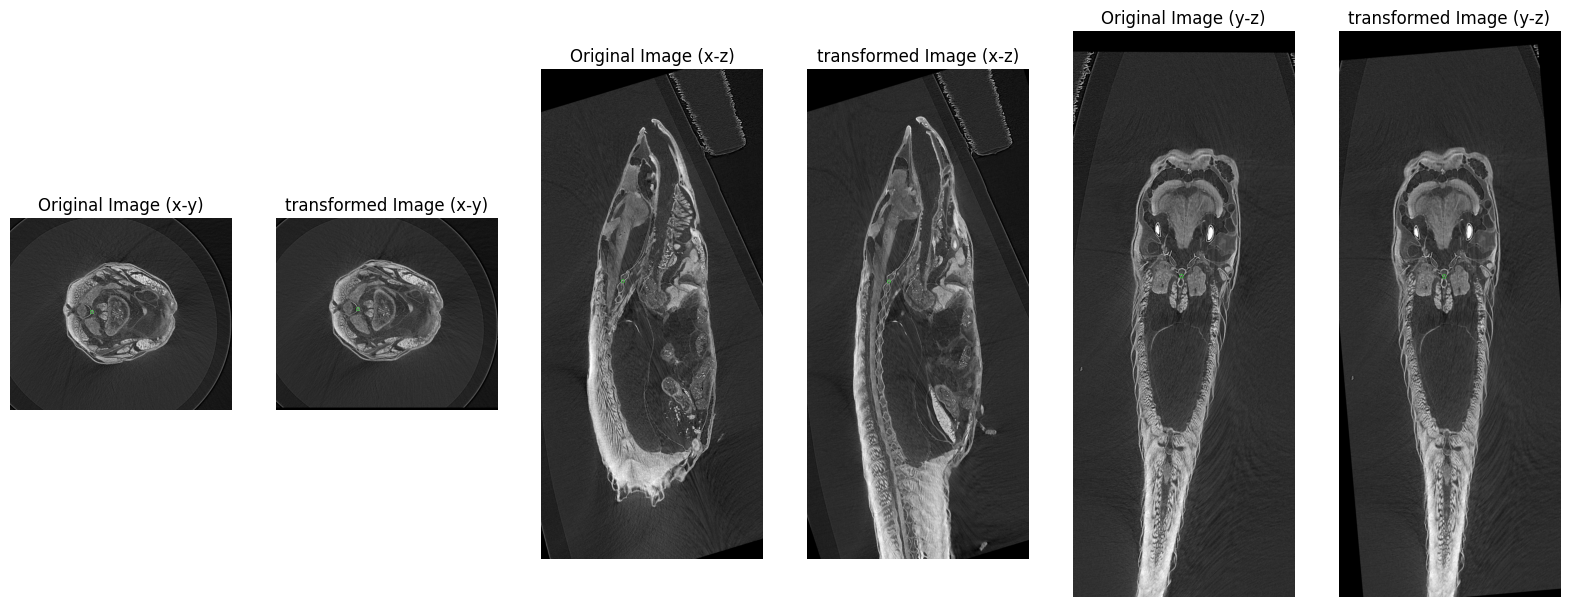

In [13]:
# translation - rotation x
rotations = torch.tensor([np.pi / 36, 0, 0])  # width (x) height(y) depth (z)
translations = torch.tensor([0., 0., 0.])
# image
medaka_tensor = torch.tensor(image_data, device=cuda).float()
medaka_transformed = affine_3d(medaka_tensor, rotations, translations, keep_original_size=True).round().cpu().numpy()
print('origin image size', medaka_tensor.shape, 'rotated image size', medaka_transformed.shape)
# landmark (vert1)
p = torch.tensor([[231., 265, 600]])
p_transformed = affine_3d_idx(image_dims, rotations, translations, p,keep_original_size=True)
# visualization
vis(image_data, medaka_transformed, p, p_transformed)

origin image size torch.Size([1387, 543, 627]) rotated image size (1387, 543, 627)


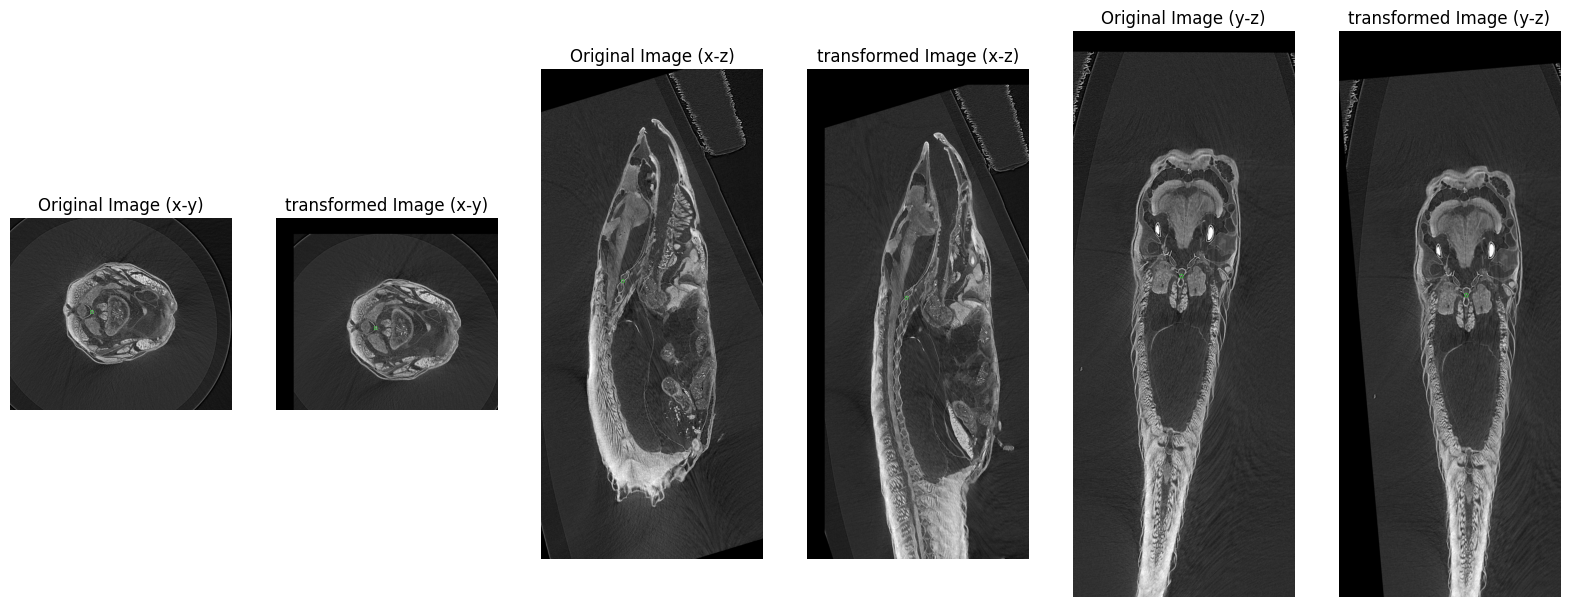

In [14]:
# translation - rotation y
rotations = torch.tensor([np.pi / 36, 0, 0])  # width (x) height(y) depth (z)
translations = torch.tensor([50., 50., 50.])
# image
medaka_tensor = torch.tensor(image_data, device=cuda).float()
medaka_transformed = affine_3d(medaka_tensor, rotations, translations, keep_original_size=True).round().cpu().numpy()
print('origin image size', medaka_tensor.shape, 'rotated image size', medaka_transformed.shape)
# landmark (vert1)
p = torch.tensor([[231., 265, 600]])
p_transformed = affine_3d_idx(image_dims, rotations, translations, p,keep_original_size=True)
# visualization
vis(image_data, medaka_transformed, p, p_transformed)